## Determining Optimal Amount of Clusters

In order to determine how many clusters to create in the ocean, use these three metrics. Code for the silhouette score does exist, however was not used as it used too much RAM for my personal machine. There are also some controversial opinions on using RMSE values in determining how many clusters to use, leaving BIC and AIC curve as the most valuable metric from the three metrics below. RMSEs did increase when there were more than 10 clusters in the Pacific Ocean and so did computation time, leaving us to test smaller amounts of clusters 

When determining the number of clusters for your ocean, consider the different sub-basins, natural divisions/transitions in various ocean chemistry values, and current. I plotted total alkalinity (TA) across the ocean and binned the data to see natural groupings with the TA data to see approximately how many clusters there should be in the Pacific Ocean. 

#### Key Metrics
##### 1. BIC/AIC Curve
##### 2. Silhoutte Score
##### 3. RMSEs for each of the clusters 

#### Prepping the Data: Importing packages and initial data processing

In [1]:
#Importing packages
# Data Processing
import pandas as pd
import numpy as np
import seawater as gsw

#sklearn modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error, silhouette_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GroupShuffleSplit
from scipy.stats import randint
from sklearn.mixture import GaussianMixture 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

C:\Users\nishi\AppData\Local\Temp\ipykernel_23748\1830462781.py:5: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as gsw


In [2]:
#Initial Data Processing
ta_initial = pd.read_csv("~/hollings/data/ta_editedcolord_pacific.csv")

#Adding AOU and PT using sw lib for continuity with ESPERs
latitude = list(ta_initial['Latitude'])
depth = list(ta_initial['Depth'])
salinity = list(ta_initial['S'])
temperature = list(ta_initial['T'])
oxygen = list(ta_initial['Oxygen'])
ptemp= gsw.ptmp(salinity, temperature, gsw.pres(depth, latitude), pr=0)
aou = gsw.satO2(salinity, ptemp)*44.6596 - (oxygen)
ta_initial["PT"] = ptemp
ta_initial["AOU"] = aou

#Additional columns
ta_sorteddepth=ta_initial.copy()
ta_sorteddepth = ta_sorteddepth.sort_values(by= "Depth")

#Addition of SST column 
ta_sorteddepth["SST"] = ta_sorteddepth.groupby(["Cruise", "Latitude", "Longitude", "year", "month", "day"])["T"].transform("first")                                                               

#Addition of sea surface salinity col
ta_sorteddepth["SSS"] = ta_sorteddepth.groupby(["Cruise", "Latitude", "Longitude", "year", "month", "day"])["S"].transform("first")

ta_ed = ta_sorteddepth.sort_index()

In [4]:
#ta_ed.to_csv("ta_orderconv.csv", index = False)

In [5]:
ta_ed = pd.read_csv("~/hollings/data/ta_orderconv.csv")

### 1. BIC/AIC Curve

In [ ]:
#Determine this by plotting the BIC or the AIC (sklearn has functions for both)
gmm_feat2 = ["Latitude", "Longitude", "SST", "SSS", "Bottom Depth"]
n_com = np.arange(2,10)
#p = GaussianMixture(n_components = 6).fit(ta_initial[gmm_feat]) 
models = [GaussianMixture(n,covariance_type='full', random_state=0).fit(ta_ed[gmm_feat2]) for n in n_com]

Text(0, 0.5, 'BIC Score')

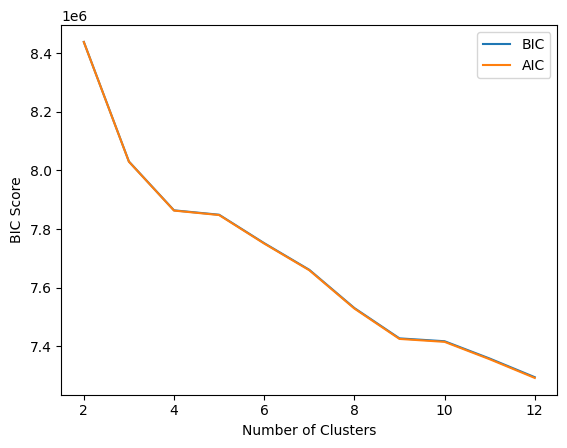

In [22]:
#Plotting BIC curve
plt.plot(n_com, [m.bic(ta_ed[gmm_feat2]) for m in models], label = "BIC")
#plt.plot(n_com, [m.aic(ta_ed[gmm_feat2]) for m in models], label = "AIC")
plt.legend(loc = "best");
plt.xlabel("Number of Clusters")
plt.ylabel("BIC Score")

ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')

#sil_scores = [silhouette_score(ta_ed[gmm_feat2], labels) for labels in clus_labels]

#### WITHOUT LONGITUDE
I also tested what the clusters would look like without longitude.

In [6]:
#Determine this by plotting the BIC or the AIC (sklearn has functions for both)
gmm_feat3 = ["Latitude", "SST", "SSS", "Bottom Depth"]
n_com3 = np.arange(2,15)
#p = GaussianMixture(n_components = 6).fit(ta_initial[gmm_feat]) 
models3 = [GaussianMixture(n,covariance_type='diag', random_state=0).fit(ta_ed[gmm_feat3]) for n in n_com3]

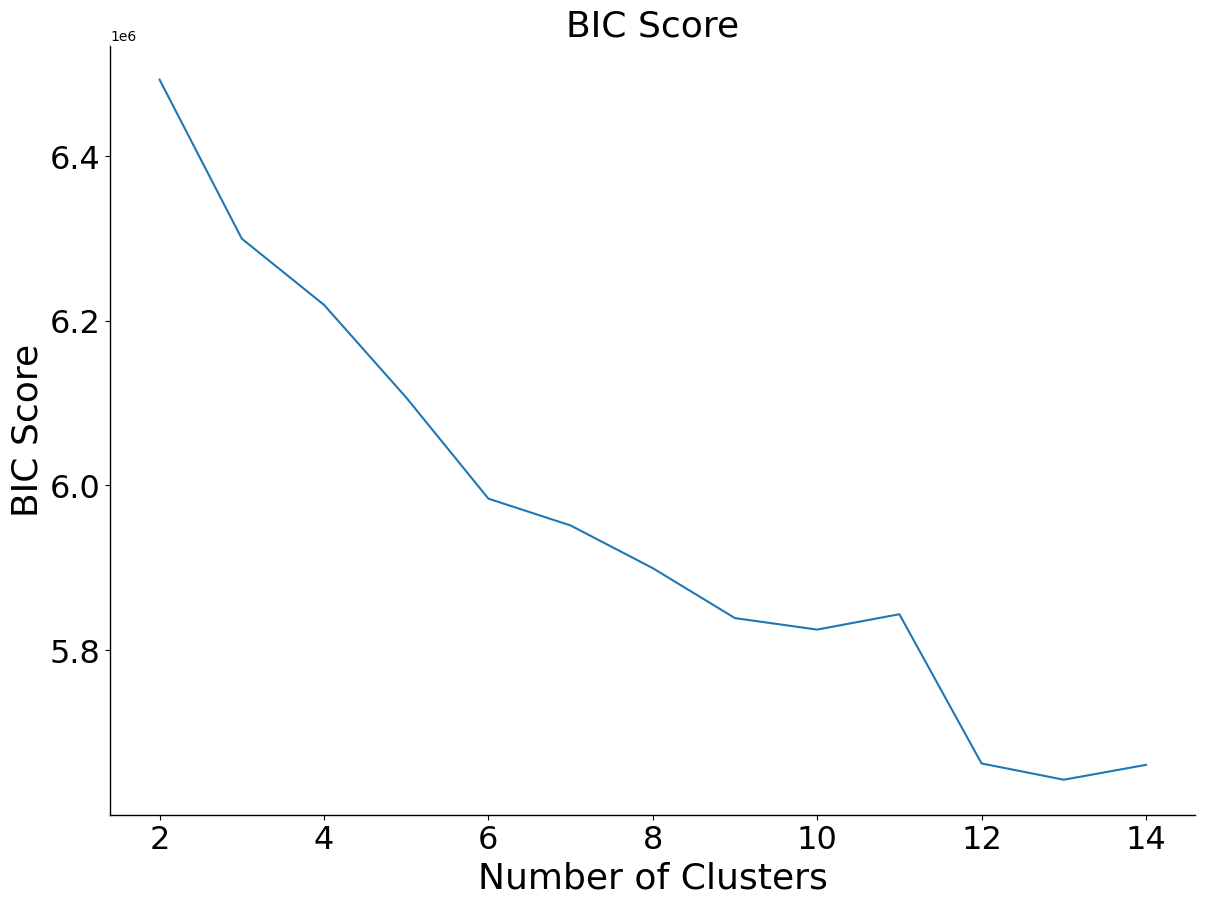

In [13]:
fig, ax = plt.subplots(figsize=(14, 10))

plt.plot(n_com3, [m.bic(ta_ed[gmm_feat3]) for m in models3], label = "BIC")
#plt.plot(n_com3, [m.aic(ta_ed[gmm_feat3]) for m in models3], label = "AIC")
#plt.legend(loc = "best");
plt.xlabel("Number of Clusters", fontsize = 26)
plt.ylabel("BIC Score", fontsize = 26)
plt.title("BIC Score", fontsize = 26)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')

#### WITHOUT LAT OR LON
Testing what the BIC/AIC curves would look like with no geographic location information.

In [9]:
#Determine this by plotting the BIC or the AIC (sklearn has functions for both)
gmm_feat4 = ["SST", "SSS", "Bottom Depth"]
n_com4 = np.arange(2,13)
#p = GaussianMixture(n_components = 6).fit(ta_initial[gmm_feat]) 
models4 = [GaussianMixture(n,covariance_type='full', random_state=0).fit(ta_ed[gmm_feat4]) for n in n_com4]

Text(0.5, 1.0, 'BIC Score, longitude excluded')

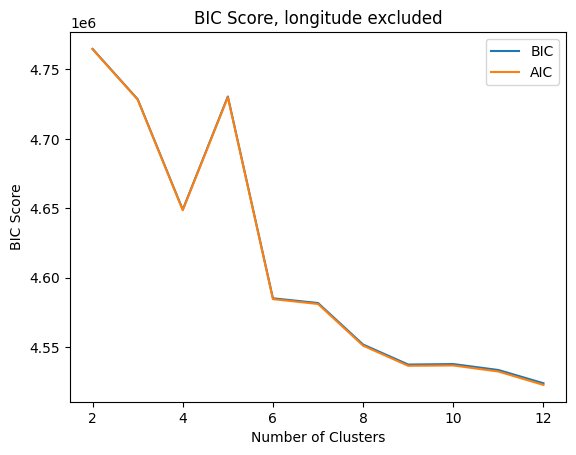

In [11]:
plt.plot(n_com4, [m.bic(ta_ed[gmm_feat4]) for m in models4], label = "BIC")
plt.plot(n_com4, [m.aic(ta_ed[gmm_feat4]) for m in models4], label = "AIC")
plt.legend(loc = "best");
plt.xlabel("Number of Clusters")
plt.ylabel("BIC Score")
plt.title("BIC Score, longitude excluded")

### 2. Silhouette Score (not running bc taking up too much memory)

In [8]:
# sil_models = [KMeans(n).fit(ta_ed[gmm_feat2]) for n in n_com] #X = ta_ed[gmm_feat2], k = #clusters, y = cluster labels 
# def labelmaker(sil_model):
#     clus_label = []
#     for i in sil_models:
#         clus_label.append(i.fit_predict(ta_ed[gmm_feat2])) #this makes the y labels!!
#     return clus_label
# clus_labels = labelmaker(sil_models)   
# clus_labels

# #for i in range(8):
# print(silhouette_score(ta_ed[gmm_feat2], clus_labels[2]))

### 3. RMSE Testing 

In [57]:
#Automating GMM clustering
def cluster_testing(n, df):
    comp_dict = {}
    gmm_feat = ["Latitude", "Longitude", "SST", "SSS", "Bottom Depth"]
    for i, cluster in enumerate(list(range(n))):
        gmm = GaussianMixture(n_components = i+1)
        gmm.fit(df[gmm_feat])
        components = gmm.predict(df[gmm_feat])
        comp_dict[i] = components
    clist_dict = {}
    for idx in comp_dict.keys(): #in each cluster #
        df["Cluster"] = comp_dict[idx]
        clst = [] 
        for j in list(np.unique(comp_dict[idx])): #for j in unique # (in the values)
            clst.append(df.loc[df["Cluster"] ==j])
        clist_dict[idx] = clst
    return clist_dict    

In [11]:
#Automating GMM clustering without LONGITUDE
def cluster_testing2(n, df):
    comp_dict = {}
    prob_dict = {}
    gmm_feat = ["Latitude", "SST", "SSS", "Bottom Depth"]
    for i, cluster in enumerate(list(range(n))):
        gmm = GaussianMixture(n_components = i+1)
        gmm.fit(df[gmm_feat])
        components = gmm.predict(df[gmm_feat])
        comp_dict[i] = components
    #return comp_dict
    clist_dict = {}
    for idx in comp_dict.keys(): #in each cluster #
        df["Cluster"] = comp_dict[idx]
        clst = [] 
        for j in list(np.unique(comp_dict[idx])): #for j in unique # (in the values)
            clst.append(df.loc[df["Cluster"] ==j])
        clist_dict[idx] = clst
    return clist_dict    

In [5]:
def cluster_testing3(n, df):
    comp_dict = {}
    gmm_feat = ["SST", "SSS", "Bottom Depth"]
    for i, cluster in enumerate(list(range(n))):
        gmm = GaussianMixture(n_components = i+1)
        gmm.fit(df[gmm_feat])
        components = gmm.predict(df[gmm_feat])
        comp_dict[i] = components
    #return comp_dict
    clist_dict = {}
    for idx in comp_dict.keys(): #in each cluster #
        df["Cluster"] = comp_dict[idx]
        clst = [] 
        for j in list(np.unique(comp_dict[idx])): #for j in unique # (in the values)
            clst.append(df.loc[df["Cluster"] ==j])
        clist_dict[idx] = clst
    return clist_dict    

In [12]:
#loading all my functions
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
def extractor(clist_dict, n): #cluster number you want to extract; func just used when i have finalized how many clusters i want
    return clist_dict[n] 
    
def make_features(c_lst):
    ft_dict = {}
    for idx, cluster in enumerate(c_lst):
        X1 = cluster["S"] #0
        X2 = cluster["PT"] #1
        X3 = cluster["Nitrate"] #2
        X4 = cluster["AOU"] #3
        X5 = cluster["Silicate"] #4
        #lat = cluster["Latitude"] #
        lon20= np.cos(np.deg2rad(cluster["Longitude"] - 20))#5
        lon110= np.cos(np.deg2rad(cluster["Longitude"] - 110)) #6
        depth = cluster["Depth"] #7
        order = cluster["order"] #8
        y = cluster["TA"] #9
        cruise = cluster["Cruise"] #10
        ft_dict[idx]=[X1, X2, X3, X4, X5, lon20, lon110, depth, order, y, cruise]
    return ft_dict

#TRAIN-TEST SPLIT: split the data for each cluster
def split_data(ft_dict):
    split_dict = {}
    for idx in ft_dict.keys(): #this is going thru each cluster
        features = ft_dict[idx]
        X, y, cruise = features[0], features[8], features[9]
        clustersp = GroupShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 40) #this is fine
        ind = list(clustersp.split(X, y, cruise))
        train_ind, test_ind = ind[0][0], ind[0][1]
        split_dict[idx] = [train_ind, test_ind]
    return split_dict

#drop y and cruise col here (need y not to be shaped this way and dont need cruise col anymore)
def rearrange(splitted_data, ft_dict):
    reshaped_data = {}
    for idx in splitted_data.keys(): #going into each of the keys 
        train_index, test_index = splitted_data[idx]
        feat_values = []
        for i in range(len(ft_dict[idx])-3): ##added a "-3" to get rid of last three elements but idk that will acutally work
            re_values = []
            train = np.array(ft_dict[idx][i])[train_index]
            train.reshape(-1,1)
            test = np.array(ft_dict[idx][i])[test_index]
            test.reshape(-1,1)
            re_values.append(train)
            re_values.append(test)
            feat_values.append(re_values)
        reshaped_data[idx] = feat_values
    return reshaped_data

def y_capture(splitted_data, ft_dict):
    y_dict = {}
    for idx in splitted_data.keys(): #going into each of the keys 
        train_index, test_index = splitted_data[idx]
        y_train = ft_dict[idx][9].iloc[train_index]
        y_test = ft_dict[idx][9].iloc[test_index]
        y_dict[idx] = (y_train, y_test)
    return y_dict

def order_capture(splitted_data, ft_dict):
    order_dict = {}
    for idx in splitted_data.keys(): #going into each of the keys 
        train_index, test_index = splitted_data[idx]
        order_train = ft_dict[idx][8].iloc[train_index]
        order_test = ft_dict[idx][8].iloc[test_index]
        order_dict[idx] = (order_train, order_test)
    return order_dict
    
def make_clust_eq(reshaped_dict):
    tpose_dt = {}
    for idx in reshaped_dict.keys(): #going into each cluster
        final_set = []
        train_eq_clust = []
        test_eq_clust = []
        for k in range(len(reshaped_dict[idx])):
            train_eq_clust.append(reshaped_dict[idx][k][0]) #this is where the problem is 
            train_clust_trans = np.transpose(train_eq_clust)
            test_eq_clust.append(reshaped_dict[idx][k][1]) #this is where the problem is 
            test_clust_trans = np.transpose(test_eq_clust)
        final_set.append(train_clust_trans)
        final_set.append(test_clust_trans)
        tpose_dt[idx] = final_set
    return tpose_dt

def rfr(tpose_dt, y_dict):
    train_rmse_lst = []
    tst_rmse_lst = []
    for idx in tpose_dt.keys():
        rf = RandomForestRegressor()
        rf.fit(tpose_dt[idx][0], y_dict[idx][0])
        
        train_pred = rf.predict(tpose_dt[idx][0])
        train_rmse = root_mean_squared_error(y_dict[idx][0], train_pred)
        train_rmse_lst.append(train_rmse)
        
        test_pred = rf.predict(tpose_dt[idx][1])
        tst_rmse = root_mean_squared_error(y_dict[idx][1], test_pred)
        tst_rmse_lst.append(tst_rmse)
    return train_rmse_lst, tst_rmse_lst

def hyp_tr(tpose_dt, y_dict):
    p_dist = {"n_estimators": randint(50, 500),
          "max_depth": randint(1,20),
          "max_features": randint(1,9)}
    hyp_dict = {}
    for idx in tpose_dt.keys(): 
        rf = RandomForestRegressor()
        rs = RandomizedSearchCV(rf, 
                        param_distributions = p_dist, 
                        n_iter = 5,
                        cv =5)
        res = rs.fit(tpose_dt[idx][0], y_dict[idx][0])
        hyp_dict[idx] = [list(res.best_params_.values())[0],list(res.best_params_.values())[1], list(res.best_params_.values())[2]]
    return hyp_dict

def best_model(tpose_dt, y_dict, hyp_dict):
    best_rmse = {}
    best_dict = {}
    for idx in tpose_dt.keys():
        best_rf = RandomForestRegressor(max_depth=hyp_dict[idx][0], n_estimators=hyp_dict[idx][1], max_features = hyp_dict[idx][2])
        best_rf.fit(tpose_dt[idx][0], y_dict[idx][0])
        best_preds = best_rf.predict(tpose_dt[idx][1])
        rmse = root_mean_squared_error(y_dict[idx][1], best_preds)
        best_rmse[idx] = rmse
        best_dict[idx] = best_preds
    return best_rmse, best_dict

In [13]:
def run_data(x): #x = eight?
    test = {}
    for i in range(12):
        a = extractor(x, i)
        b = make_features(a)
        c = split_data(b)
        d = rearrange(c,b)
        e = y_capture(c,b)
        f = make_clust_eq(d)
        g = rfr(f,e)
        test[i] = g
    return test

#### Testing with 12 clusters

#### Fixed training and testing rmses

In [14]:
twfixdi = cluster_testing2(12, ta_ed)

In [ ]:
ttfixdi = run_data(twfixdi)

In [ ]:
avg_rmse_lstfxdi = []
tftdi = ttfixdi[0] 
for idx in tftdi.keys():
    av_rmse = sum(tftdi[idx][0])/len(tftdi[idx][0])
    avg_rmse_lstfxdi.append(av_rmse)

print(avg_rmse_lstfxdi)
print(min(avg_rmse_lstfxdi))

##test data
avg_rmse_lstfxtstdi = []
tftdi = ttfixdi[0] 
for idx in tftdi.keys():
    av_rmse = sum(tftdi[idx][1])/len(tftdi[idx][1])
    avg_rmse_lstfxtstdi.append(av_rmse)

print(avg_rmse_lstfxtstdi)
print(min(avg_rmse_lstfxtstdi))

In [17]:
twfix = cluster_testing2(12, ta_ed)

In [24]:
ttfix = run_data(twfix)

In [25]:
ttfix

({0: ([1.8294987266138163], [4.9255972762004445]),
  1: ([1.6446542445935928, 1.992021656615879],
   [4.377048012251512, 5.116153010483367]),
  2: ([1.5405901649442892, 3.1999140200825797, 1.5930547270514255],
   [4.031581685702519, 8.036919989055868, 4.535760612245199]),
  3: ([1.5717818870102893,
    1.7231357709634265,
    1.5201719580929656,
    3.402202225006762],
   [4.027897277337238,
    5.040204064466872,
    4.148729690067194,
    8.032648347147472]),
  4: ([1.5152483501497567,
    5.507110452754684,
    1.395741398238809,
    2.2508200750239533,
    1.7228950047225617],
   [4.128547356878929,
    16.654916852567183,
    3.4955999116131125,
    6.8561774788740895,
    4.9106618849606205]),
  5: ([1.7340488473702946,
    6.173601835553479,
    1.5107646980390979,
    2.1339651799902914,
    1.7959024022301093,
    1.3499358768844136],
   [4.60946115087975,
    13.388955540088185,
    4.174375665824724,
    5.64234911243247,
    5.018619938050996,
    3.515738890013437]),
  6: 

In [32]:
avg_rmse_lstfx = []
tft = ttfix[0] 
for idx in tft.keys():
    av_rmse = sum(tft[idx][0])/len(tft[idx][0])
    avg_rmse_lstfx.append(av_rmse)

print(avg_rmse_lstfx)
print(min(avg_rmse_lstfx))

##test data
avg_rmse_lstfxtst = []
tft = ttfix[0] 
for idx in tft.keys():
    av_rmse = sum(tft[idx][1])/len(tft[idx][1])
    avg_rmse_lstfxtst.append(av_rmse)

print(avg_rmse_lstfxtst)
print(min(avg_rmse_lstfxtst))

[1.8294987266138163, 1.818337950604736, 2.111186304026098, 2.054322960268361, 2.478363056177953, 2.4497031400112808, 2.4216148363075334, 2.2938702312567694, 2.35489925398166, 2.2773567105830415, 2.030153913327, 2.2167269289014233]
1.818337950604736
[4.9255972762004445, 4.74660051136744, 5.534754095667862, 5.312369844754693, 7.209180696978787, 6.058250049548261, 5.962461696838746, 6.042908625041598, 5.997793731967144, 5.686751551061258, 5.296987108746304, 5.548725180511165]
4.74660051136744


Text(0, 0.5, 'Avg RMSE')

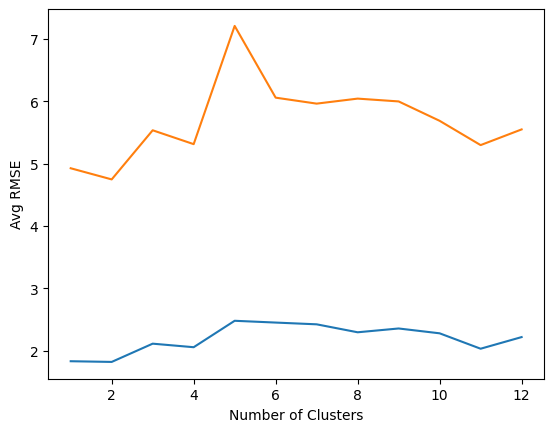

In [33]:
y_rmse5 = avg_rmse_lstfx
x_rmse5 = [x+1 for x in range(len(y_rmse5))]
plt.plot(x_rmse5, y_rmse5)

y_rmse6 = avg_rmse_lstfxtst
x_rmse6 = [x+1 for x in range(len(y_rmse6))]
plt.plot(x_rmse6, y_rmse6)

plt.xlabel("Number of Clusters")
plt.ylabel("Avg RMSE") 

In [13]:
tw = cluster_testing(12, ta_ed)

In [14]:
tt = run_data(tw)

In [17]:
avg_rmse_lst4 = []
for idx in tt.keys():
    av_rmse = sum(tt[idx])/len(tt[idx])
    avg_rmse_lst4.append(av_rmse)

print(avg_rmse_lst4)
min(avg_rmse_lst4)

[4.882241779127885, 4.7152076307830075, 4.820303095150498, 5.640721661787651, 5.5558931967952105, 5.802960919486922, 4.8363863901153525, 5.0711895692889435, 4.894286017102875, 4.94156126708587, 4.96272683926215, 5.733971660588327]


4.7152076307830075

Text(0, 0.5, 'Avg RMSE')

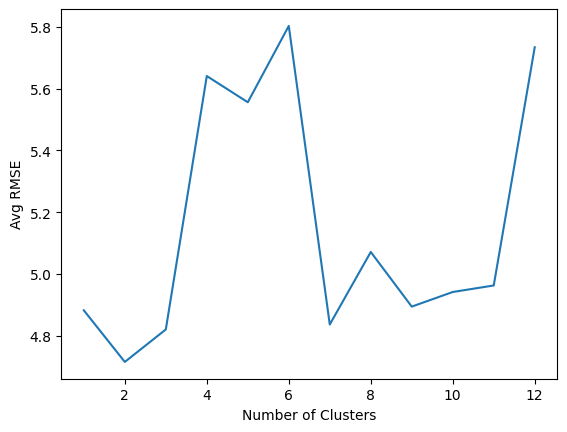

In [18]:
y_rmse4 = avg_rmse_lst4
x_rmse4 = [x+1 for x in range(len(y_rmse4))]
plt.plot(x_rmse4, y_rmse4)
plt.xlabel("Number of Clusters")
plt.ylabel("Avg RMSE") 

#### Graphing each of the clusters

In [7]:
#for each # of clusters, append cluster # to a df
def cluster_map(clust_dict):
    catdict = {}
    for idx in clust_dict.keys(): #making new df concat portion
        k = pd.concat([clust_dict[idx][j] for j in range(len(clust_dict[idx]))])  
        catdict[idx] = k
    return catdict

In [74]:
tstw = cluster_map(tw)

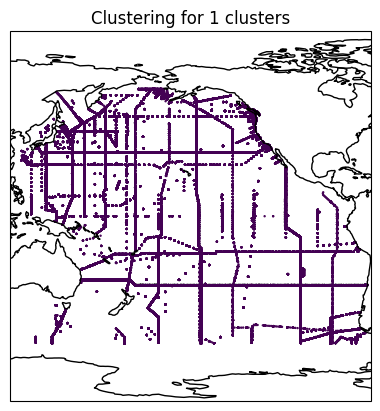

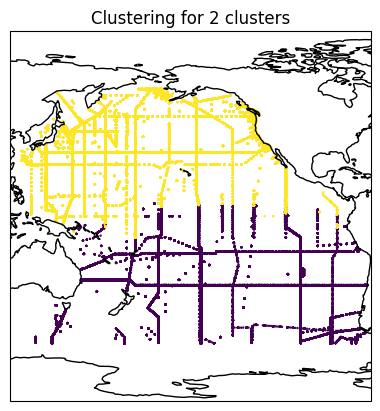

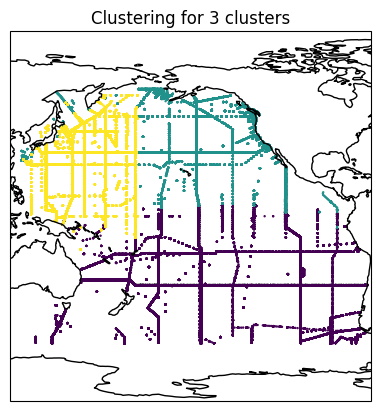

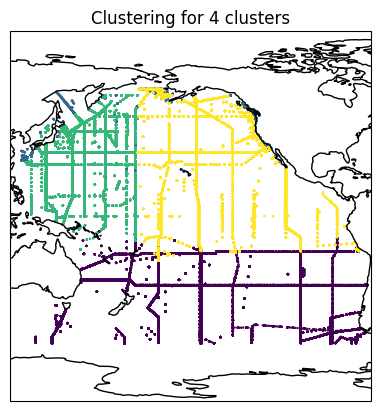

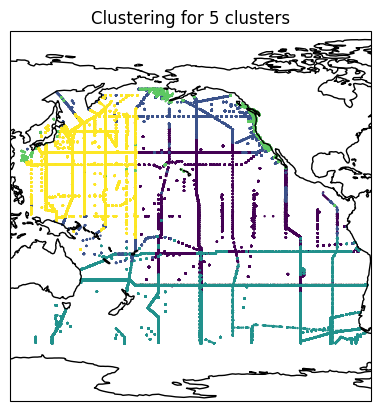

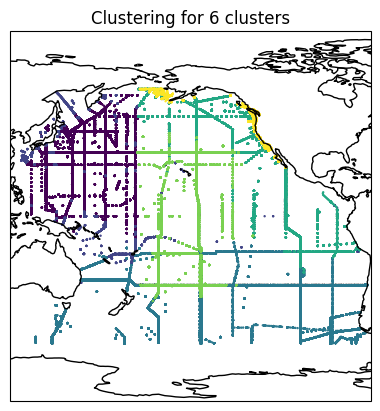

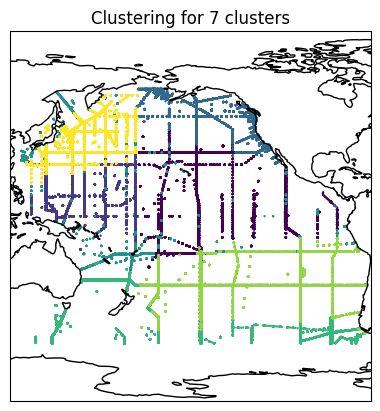

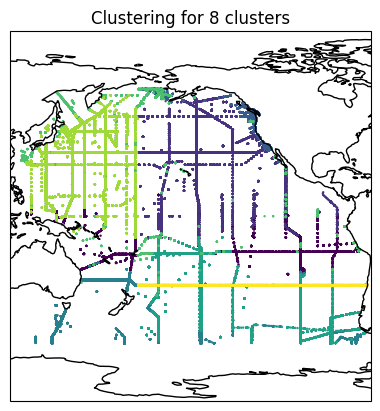

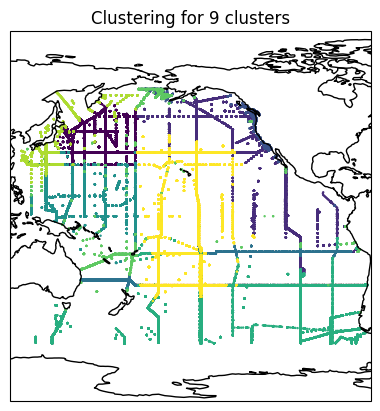

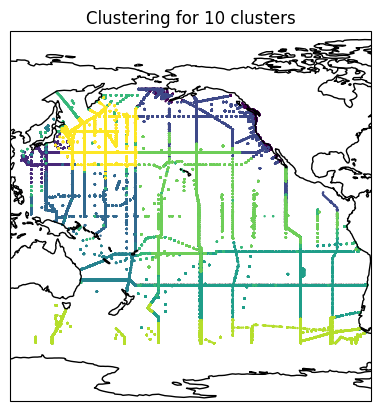

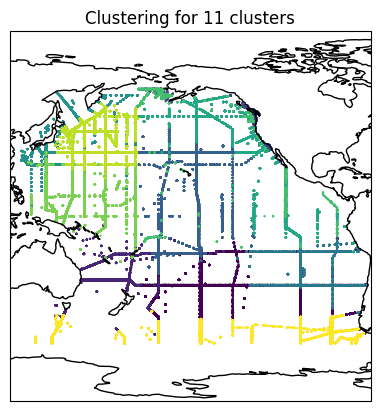

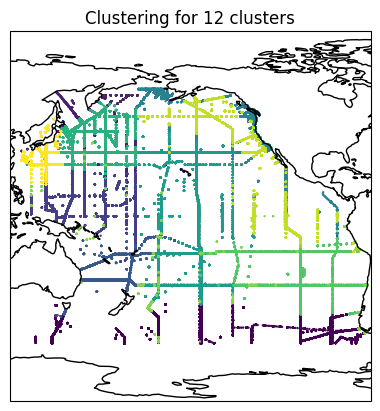

In [82]:
for jdx in tstw.keys(): #mapping portion
    latex = tstw[jdx]["Latitude"]
    lonex = tstw[jdx]["Longitude"]
    clustcol = tstw[jdx]["Cluster"]

    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines()
    ax.set_extent([120,-70,-60,60])
    ax.scatter(lonex, latex,.5, c = clustcol, transform=ccrs.PlateCarree())
    ax.set_title(f'Clustering for {jdx+1} clusters')
    plt.savefig(f'{jdx+1}Clusters.png')
    plt.show()

In [ ]:
#### Without longitude as a part of the GMM

In [ ]:
twlon = cluster_testing2(12, ta_ed)
ttlon = run_data(tw)

ttlon

In [11]:
avg_rmse_lst5 = []
for idx in ttlon.keys():
    av_rmse = sum(ttlon[idx])/len(ttlon[idx])
    avg_rmse_lst5.append(av_rmse)

print(avg_rmse_lst5)
min(avg_rmse_lst5)

[4.962698329456915, 4.841179246440504, 5.3158551768533115, 5.232836013485526, 5.002607475505906, 5.735480952390211, 6.476449324786855, 5.91789949030699, 6.2378759194296896, 5.720985543975468, 5.7782160667522, 5.985321516868852]


4.841179246440504

Text(0.5, 1.0, 'Avg RMSE, longitude excluded')

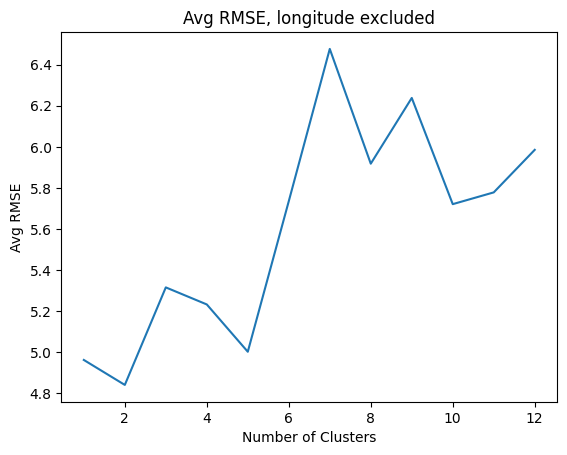

In [12]:
y_rmse5 = avg_rmse_lst5
x_rmse5 = [x+1 for x in range(len(y_rmse5))]
plt.plot(x_rmse5, y_rmse5)
plt.xlabel("Number of Clusters")
plt.ylabel("Avg RMSE") 
plt.title("Avg RMSE, longitude excluded") 

In [52]:
## adding predicted probs for each cluster
#to get probabilities for 8 clusters (current best without the 100 km coastline mask)
comp3= models3[6].predict(ta_ed[gmm_feat3])
prob3 = models3[6].predict_proba(ta_ed[gmm_feat3])
prob_8cl_df = pd.DataFrame(prob3, columns = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5", "Cluster 6", "Cluster 7", "Cluster 8"])

In [ ]:
tstwlon = cluster_map(twlon)

In [21]:
#converting to csv to experiment with overlapping clusters; this doesnt have the 100 km taken out yet
tstwlon[7].to_csv("ta_twlon8.csv", index = False)

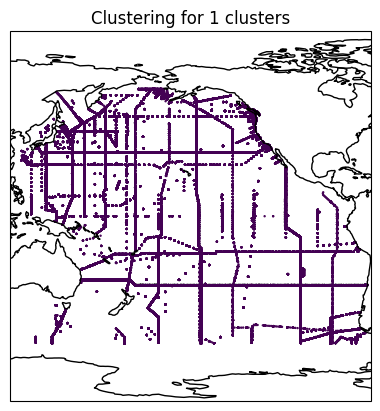

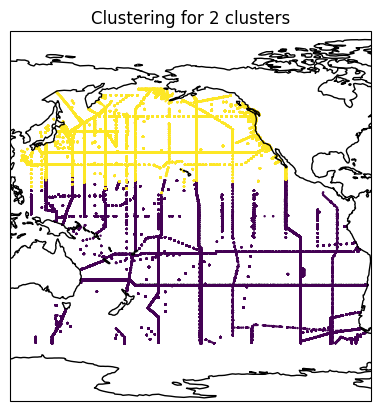

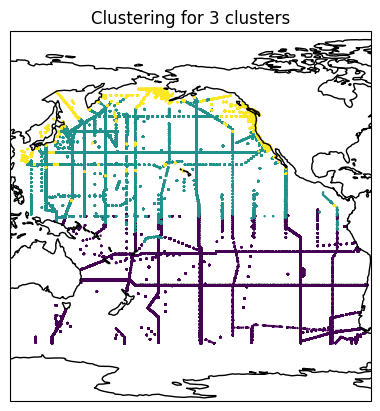

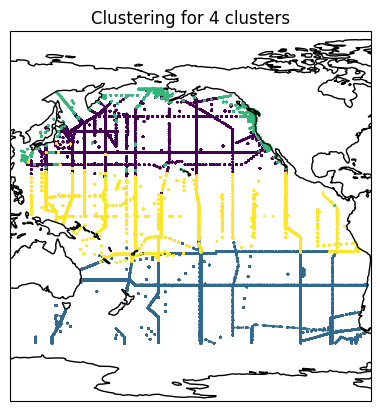

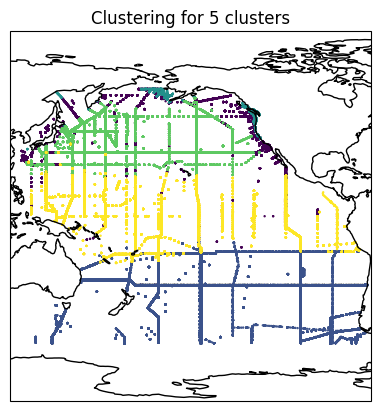

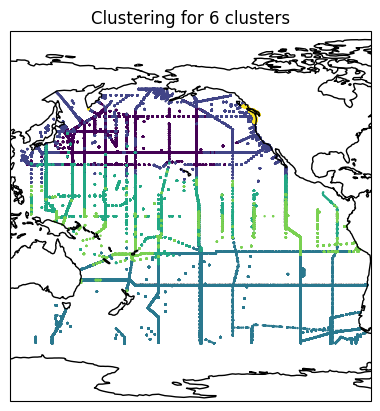

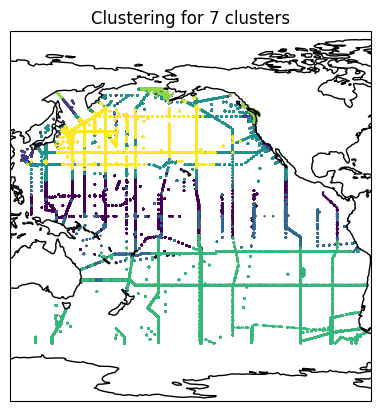

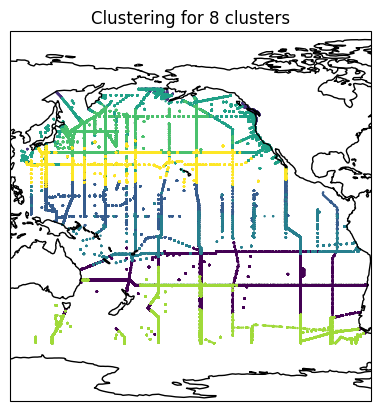

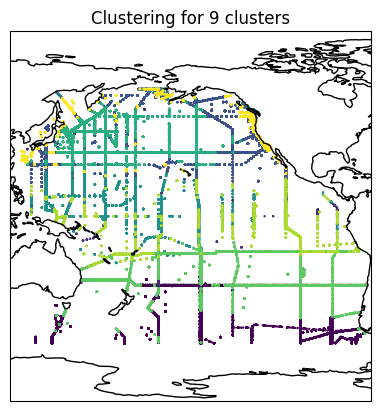

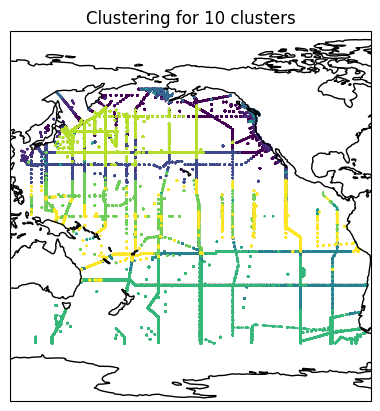

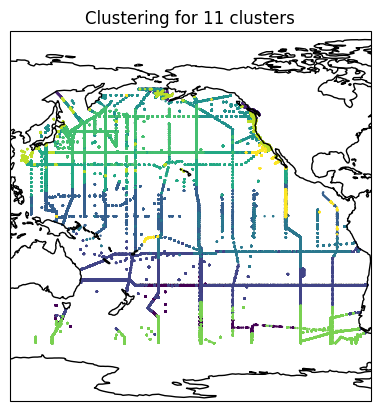

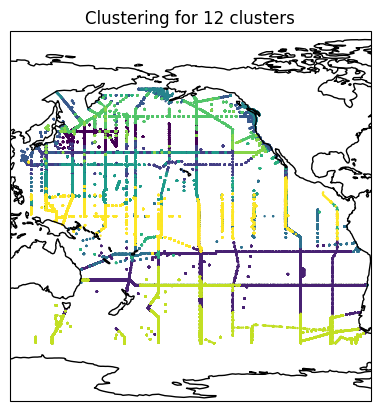

In [88]:
for jdx in tstwlon.keys(): #mapping portion
    latex = tstwlon[jdx]["Latitude"]
    lonex = tstwlon[jdx]["Longitude"]
    clustcol = tstwlon[jdx]["Cluster"]

    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines()
    ax.set_extent([120,-70,-60,60])
    ax.scatter(lonex, latex,.5, c = clustcol, transform=ccrs.PlateCarree())
    ax.set_title(f'Clustering for {jdx+1} clusters')
    plt.savefig(f'{jdx+1}Clusters_nolon.png')
    plt.show()